## We attempt to create a predictor that can predict the outcome of a match given previous wins (2017 IPL Matches).<br>
### Using dataset: matches.csv (636 rows)
<p>
    We create a basic predictor that uses a neural network to predict the match outcome. The model will exported to Django where a web interface will interact with the model.<br>
    </p>

In [1]:
import pandas as pd
import numpy as np
import keras
from keras.utils import to_categorical, plot_model
from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras import losses
from keras.layers import Dense
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, log_loss, recall_score
import matplotlib.pyplot as plt

In [2]:
# Loading dataset
data = pd.read_csv("matches.csv")

In [3]:
data.head()

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,403,2013,Peshawar,4/17/2013,Islamabad United,Karachi Kings,Islamabad United,bat,normal,0,Islamabad United,87,0,Lewis Gregory,"Arbab Niaz Stadium , Peshawar",Aleem Dar,C Shamshuddin,NaN
1,78,2008,Peshawar,5/1/2008,Islamabad United,Lahore Qalandars,Islamabad United,bat,normal,0,Islamabad United,45,0,Lewis Gregory,"Arbab Niaz Stadium , Peshawar",RE Koertzen,GA Pratapkumar,NaN
2,314,2012,Peshawar,4/8/2012,Islamabad United,Lahore Qalandars,Lahore Qalandars,field,normal,0,Islamabad United,22,0,Lewis Gregory,"Arbab Niaz Stadium , Peshawar",BF Bowden,VA Kulkarni,NaN
3,389,2013,Peshawar,4/8/2013,Islamabad United,Lahore Qalandars,Lahore Qalandars,field,normal,0,Islamabad United,19,0,Lewis Gregory,"Arbab Niaz Stadium , Peshawar",Aleem Dar,S Das,NaN
4,113,2008,Peshawar,5/26/2008,Karachi Kings,Islamabad United,Islamabad United,field,normal,0,Islamabad United,0,5,Lewis Gregory,"Arbab Niaz Stadium , Peshawar",BF Bowden,K Hariharan,NaN


In [4]:
# Removing unwanted columns
data.drop(columns=['venue', 'player_of_match', 'dl_applied','umpire1','umpire2','umpire3','date','city','season','id'], inplace=True)

In [5]:
# Label encoding toss_decision
data.toss_decision = data.toss_decision.map({'bat':1, 'field':0})

In [6]:
# Encoding result
data.result = data.result.map({'normal':1, 'tie':2, 'no result':0})

In [7]:
r = len(data.team2.unique())
teams = data.team1.unique()
mapping = {}

In [8]:
for i in range(5): # There are 14 teams.
    mapping[teams[i]] = i

In [9]:
data.toss_winner = data.toss_winner.map(mapping)

In [10]:
# Encoding team data in numeric form
data.team1 = data.team1.map(mapping)
data.team2 = data.team2.map(mapping)
mapping # A value is repeated

{'Islamabad United': 0,
 'Karachi Kings': 1,
 'Multan Sultan': 2,
 'Peshawar Zalmi': 3,
 'Quetta Gladiator': 4}

In [11]:
data.winner = data.winner.map(mapping)

In [12]:
# Removing NA Fields
data.dropna(axis=0,inplace=True)

In [13]:
data.winner = data.winner.astype(int)

In [14]:
data.head()

,team1,team2,toss_winner,toss_decision,result,winner,win_by_runs,win_by_wickets
0,0.0,1.0,0.0,1,1,0,87,0
4,1.0,0.0,0.0,0,1,0,0,5
5,1.0,0.0,0.0,0,1,0,0,7
6,2.0,0.0,2.0,1,1,0,0,8
7,2.0,0.0,0.0,0,1,0,0,5


In [15]:
len(data)

107

<p>
    While we think that <b>win_by_runs</b> and <b> win_by_wickets </b> are important metrics for the dataset, we are dropping it for user's simplicity.</p>

In [16]:
data.drop(columns=["win_by_runs", "win_by_wickets"], axis=1, inplace=True)

In [17]:
data.head()

,team1,team2,toss_winner,toss_decision,result,winner
0,0.0,1.0,0.0,1,1,0
4,1.0,0.0,0.0,0,1,0
5,1.0,0.0,0.0,0,1,0
6,2.0,0.0,2.0,1,1,0
7,2.0,0.0,0.0,0,1,0


In [18]:
data.drop(columns=["toss_decision", "result"], inplace=True)

In [19]:
data.head()

,team1,team2,toss_winner,winner
0,0.0,1.0,0.0,0
4,1.0,0.0,0.0,0
5,1.0,0.0,0.0,0
6,2.0,0.0,2.0,0
7,2.0,0.0,0.0,0


In [20]:
labels = data.winner.values
features = data.drop(columns=["winner"], axis=1).values

labels_copy = data.winner.values
features_copy = data.drop(columns=["winner"], axis=1).values


In [21]:
features.shape

(107, 3)

In [22]:
# We have three input dim
labels.shape

(107,)

In [23]:
# As there is no activaton function that can predict 'winner', we are one hot encoding it.
labels = to_categorical(labels)

In [24]:
labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0.

In [25]:
labels.shape

(107, 5)

In [26]:
# Now we will use a softmax which will provide probs for 14 different classes aka teams.

In [27]:
features_train, features_test, labels_train,labels_test = train_test_split(features, labels, shuffle=True, random_state=42)
features_copy_train, features_copy_test, labels_copy_train,labels_copy_test = train_test_split(features, labels, shuffle=True, random_state=42)

In [28]:
len(features_train)

80

In [29]:
len(features_test)

27

In [30]:
# Creating model
model = Sequential()
model.add(Dense(100, activation="relu", input_dim=features.shape[1]))
model.add(Dense(75, activation="relu"))
model.add(Dense(75, activation="relu"))
model.add(Dense(labels.shape[1], activation="softmax"))
model.compile(optimizer=keras.optimizers.Adam(lr=0.001), loss=losses.categorical_crossentropy, metrics=["accuracy"])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 75)                7575      
_________________________________________________________________
dense_2 (Dense)              (None, 75)                5700      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 380       
Total params: 14,055
Trainable params: 14,055
Non-trainable params: 0
_________________________________________________________________


In [32]:
# Let us train the model
history = model.fit(features_train, labels_train, epochs=1000, validation_data=(features_test, labels_test), batch_size=25)

Epoch 1/1000
4/4 [==============================] - 1s 201ms/step - loss: 1.5757 - accuracy: 0.2943 - val_loss: 1.5142 - val_accuracy: 0.2222
Epoch 2/1000
4/4 [==============================] - 0s 20ms/step - loss: 1.5056 - accuracy: 0.4263 - val_loss: 1.4514 - val_accuracy: 0.4444
Epoch 3/1000
4/4 [==============================] - 0s 20ms/step - loss: 1.4876 - accuracy: 0.4040 - val_loss: 1.4086 - val_accuracy: 0.4444
Epoch 4/1000
4/4 [==============================] - 0s 20ms/step - loss: 1.4481 - accuracy: 0.4120 - val_loss: 1.3841 - val_accuracy: 0.4444
Epoch 5/1000
4/4 [==============================] - 0s 21ms/step - loss: 1.4383 - accuracy: 0.4433 - val_loss: 1.3725 - val_accuracy: 0.4815
Epoch 6/1000
4/4 [==============================] - 0s 22ms/step - loss: 1.3994 - accuracy: 0.5023 - val_loss: 1.3662 - val_accuracy: 0.4815
Epoch 7/1000
4/4 [==============================] - 0s 20ms/step - loss: 1.4270 - accuracy: 0.4490 - val_loss: 1.3635 - val_accuracy: 0.4815
Epoch 8/1000

In [33]:
pred = model.predict(features_test)
e = model.evaluate(features_test, labels_test)
print ("Loss: ", e[0])
print ("Accuracy on the test set: ", e[1])

1/1 [==============================] - 0s 17ms/step - loss: 1.5144 - accuracy: 0.5185
Loss:  1.5144294500350952
Accuracy on the test set:  0.5185185074806213


In [34]:
pred

array([[6.8134710e-02, 3.1372686e-03, 1.2058939e-02, 1.1607923e-02,
        9.0506113e-01],
       [1.6314909e-04, 9.9960345e-01, 3.7313890e-05, 1.9512467e-04,
        1.0210300e-06],
       [3.1990254e-01, 9.7339666e-03, 6.6464674e-01, 5.7168626e-03,
        8.5639735e-09],
       [7.3903784e-06, 2.3287472e-03, 1.7539039e-01, 8.0684966e-01,
        1.5423745e-02],
       [5.1616675e-01, 4.6192220e-01, 2.1896254e-02, 1.4826128e-05,
        9.2490158e-09],
       [6.6150683e-01, 2.1536455e-04, 2.9296279e-03, 3.3534661e-01,
        1.5899307e-06],
       [7.9644478e-06, 5.1670889e-03, 9.9049473e-01, 3.0640565e-04,
        4.0237950e-03],
       [2.0784629e-03, 6.1390084e-01, 3.7936953e-01, 4.6512047e-03,
        1.7649587e-08],
       [9.8409373e-01, 3.1031611e-06, 2.9461312e-06, 1.5874283e-02,
        2.6099944e-05],
       [3.1990254e-01, 9.7339666e-03, 6.6464674e-01, 5.7168626e-03,
        8.5639735e-09],
       [2.0784629e-03, 6.1390084e-01, 3.7936953e-01, 4.6512047e-03,
        1.76

In [35]:
# Now we we will use np.argmax to get the max probability and the index
pred = np.argmax(pred, axis=1)

In [36]:
pred

array([4, 1, 2, 3, 0, 0, 2, 1, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1, 0, 1, 1, 2,
       2, 2, 0, 0, 1])

In [37]:
decoded_labels_test = np.argmax(labels_test, axis=1)

In [38]:
decoded_labels_test

array([1, 2, 0, 2, 1, 3, 4, 1, 0, 2, 1, 1, 0, 2, 2, 3, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 0, 1])

In [39]:
# Checking accuracy (Using a 3 hidden layer neural network)
print ("The accuracy of the mode is : ", accuracy_score(decoded_labels_test, pred))

The accuracy of the mode is :  0.5185185185185185


In [40]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [57]:
!pip install spafe
!pip install pip install scikit-plot

     |████████████████████████████████| 81kB 5.0MB/s 


Random Forest Accuracy: 0.5925925925925926
                  precision    recall  f1-score   support

Islamabad United       0.33      0.40      0.36         5
   Karachi Kings       0.64      0.64      0.64        11
   Multan Sultan       0.67      0.86      0.75         7
  Peshawar Zalmi       0.00      0.00      0.00         1
Quetta Gladiator       1.00      0.33      0.50         3

        accuracy                           0.59        27
       macro avg       0.53      0.45      0.45        27
    weighted avg       0.60      0.59      0.58        27

root mean square: 1.1055415967851334
score: 0.10181451612903225
mean absolute error: 0.6296296296296297
mean squared error: 1.2222222222222223
pearson_coef: 0.4889826260092473
p_value: 0.009644894550239399




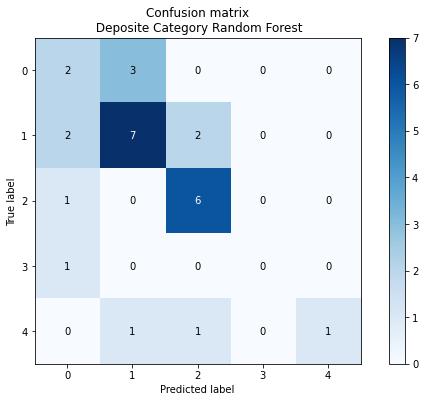

Accuracy KNN: 0.5185185185185185
                  precision    recall  f1-score   support

Islamabad United       0.20      0.20      0.20         5
   Karachi Kings       0.55      0.55      0.55        11
   Multan Sultan       0.60      0.86      0.71         7
  Peshawar Zalmi       0.00      0.00      0.00         1
Quetta Gladiator       1.00      0.33      0.50         3

        accuracy                           0.52        27
       macro avg       0.47      0.39      0.39        27
    weighted avg       0.53      0.52      0.50        27

root mean square: 1.1385500851066221
score: 0.0473790322580645
mean absolute error: 0.7037037037037037
mean squared error: 1.2962962962962963
pearson_coef: 0.43093481713028553
p_value: 0.024827250899770188




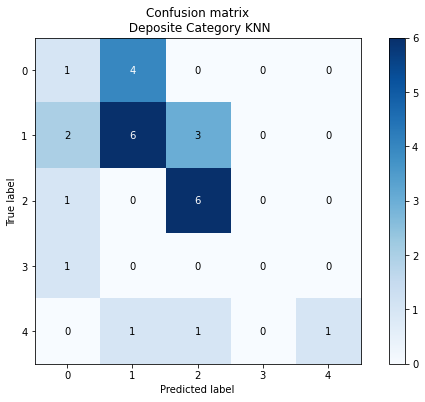

Accuracy SVM: 0.5185185185185185
                  precision    recall  f1-score   support

Islamabad United       0.50      1.00      0.67         5
   Karachi Kings       0.67      0.18      0.29        11
   Multan Sultan       0.42      0.71      0.53         7
  Peshawar Zalmi       0.00      0.00      0.00         1
Quetta Gladiator       1.00      0.67      0.80         3

        accuracy                           0.52        27
       macro avg       0.52      0.51      0.46        27
    weighted avg       0.58      0.52      0.47        27

root mean square: 1.0
score: 0.2651209677419355
mean absolute error: 0.6296296296296297
mean squared error: 1.0
pearson_coef: 0.6494487805573562
p_value: 0.0002467731399480387




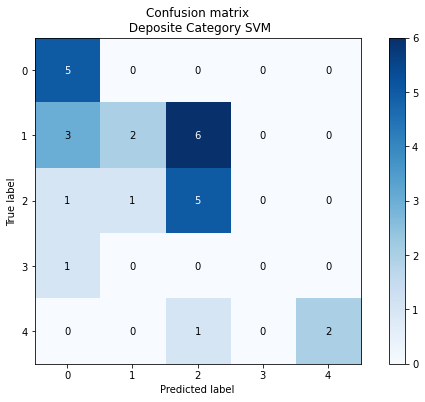

Voting Score 0.5555555555555556
                  precision    recall  f1-score   support

Islamabad United       0.33      0.40      0.36         5
   Karachi Kings       0.60      0.55      0.57        11
   Multan Sultan       0.60      0.86      0.71         7
  Peshawar Zalmi       0.00      0.00      0.00         1
Quetta Gladiator       1.00      0.33      0.50         3

        accuracy                           0.56        27
       macro avg       0.51      0.43      0.43        27
    weighted avg       0.57      0.56      0.54        27

root mean square: 1.1221672153735642
score: 0.07459677419354838
mean absolute error: 0.6666666666666666
mean squared error: 1.2592592592592593
pearson_coef: 0.46698702705547585
p_value: 0.014058815041620473




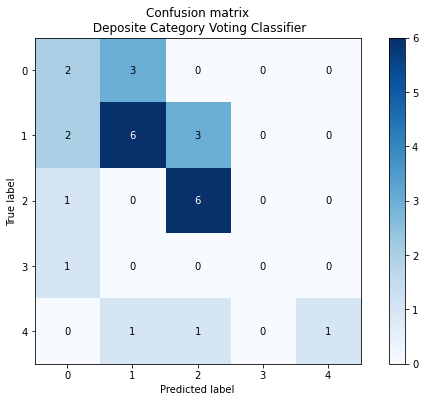

[2 0 2 1 0 2 1 1 2 4 0 1 2 1 2 2 1 2 0 1 0 0 1 1 1 2 1]
[('Multan Sultan', 10), ('Karachi Kings', 10), ('Islamabad United', 6), ('Quetta Gladiator', 1)]
[('Multan Sultan', 10), ('Karachi Kings', 10), ('Islamabad United', 6), ('Quetta Gladiator', 1)]
[('Multan Sultan', 10), ('Karachi Kings', 10), ('Islamabad United', 6), ('Quetta Gladiator', 1)]


In [58]:

from collections import Counter

import numpy as np
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
import joblib
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

def results(target_test, predicted_test,ModelName,labels):
    target_names = labels
    print(classification_report(target_test, predicted_test, target_names=target_names))
    y_test = target_test
    preds = predicted_test
    rms = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(preds)), 2)))
    score = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    pearson_coef, p_value = stats.pearsonr(y_test, preds)

    print("root mean square:", rms)
    print("score:", score)
    print("mean absolute error:", mae)
    print("mean squared error:", mse)
    print("pearson_coef:", pearson_coef)
    print("p_value:", p_value)
    print("=======================================================================\n\n")
    skplt.metrics.plot_confusion_matrix(
        y_test,
        preds,
         figsize=(10, 6), title="Confusion matrix\n Deposite Category "+ModelName)
    plt.xlim(-0.5, len(np.unique(y_test)) - 0.5)
    plt.ylim(len(np.unique(y_test)) - 0.5, -0.5)
    plt.savefig('cvroc.png')
    plt.show()

def PMF():
    warnings.filterwarnings('ignore')


    # Loading dataset
    data = pd.read_csv("matches.csv")

    data.head()

    # Removing unwanted columns
    data.drop(columns=['venue', 'player_of_match', 'dl_applied','umpire1','umpire2','umpire3','date','city','season','id'], inplace=True)

    # Label encoding toss_decision
    data.toss_decision = data.toss_decision.map({'bat':1, 'field':0})

    # Encoding result
    data.result = data.result.map({'normal':1, 'tie':2, 'no result':0})

    r = len(data.team2.unique())
    teams = data.team1.unique()
    mapping = {}

    for i in range(5): # There are 14 teams.
        mapping[teams[i]] = i

    data.toss_winner = data.toss_winner.map(mapping)

    # Encoding team data in numeric form
    data.team1 = data.team1.map(mapping)
    data.team2 = data.team2.map(mapping)
    mapping # A value is repeated

    label=list(mapping)

    data.winner = data.winner.map(mapping)

    # Removing NA Fields
    data.dropna(axis=0,inplace=True)

    data.winner = data.winner.astype(int)

    data.head()

    len(data)

    data.drop(columns=["win_by_runs", "win_by_wickets"], axis=1, inplace=True)

    data.head()

    data.drop(columns=["toss_decision", "result"], inplace=True)

    data.head()

    labels = data.winner.values
    features = data.drop(columns=["winner"], axis=1).values

    labels_copy = data.winner.values
    features_copy = data.drop(columns=["winner"], axis=1).values

    features.shape

    # We have three input dim
    labels.shape

    # As there is no activaton function that can predict 'winner', we are one hot encoding it.
    #labels = to_categorical(labels)

    labels

    labels.shape

    # Now we will use a softmax which will provide probs for 14 different classes aka teams.

    #features_train, features_test, labels_train,labels_test = train_test_split(features, labels, shuffle=True, random_state=42)
    #features_copy_train, features_copy_test, labels_copy_train,labels_copy_test = train_test_split(features, labels, shuffle=True, random_state=42)

    #len(features_train)

    #len(features_test)

    # converting labels into numeric
    le = preprocessing.LabelEncoder()
    target=le.fit_transform(labels)
    # features = preprocessing.MinMaxScaler().fit_transform(features)
    feature_train, feature_test, target_train, target_test = train_test_split(features, target)
    #Create a Gaussian Classifier
    clff=RandomForestClassifier(n_estimators=800)
    #Train the model using the training sets y_pred=clf.predict(X_test)
    clff = clff.fit(feature_train,target_train)
    y_predd1=clff.predict(feature_test)
    # Model Accuracy, how often is the classifier correct?
    print("Random Forest Accuracy:",metrics.accuracy_score(target_test, y_predd1))
    results(target_test, y_predd1,"Random Forest",label)

    target_names = labels

    #sns.heatmap(confusion_matrix(target_test,y_predd1), annot=True, cmap='Blues')
    model_path = 'Models\\'
    joblib.dump(clff, model_path+"model_3000.sav")
    #Create a KNN Classifier
    knn=KNeighborsClassifier()
    #Train the model using the training sets y_pred=clf.predict(X_test)
    knn = knn.fit(feature_train,target_train)
    y_predd2=knn.predict(feature_test)
    # Model Accuracy, how often is the classifier correct?
    print("Accuracy KNN:",metrics.accuracy_score(target_test, y_predd2))
    results(target_test, y_predd2,"KNN",label)
    model_path = 'Models\\'
    joblib.dump(knn, model_path+"model_knn.sav")
    # training a linear SVM classifier
    svm_model_linear = SVC(kernel = 'linear', C = 1).fit(feature_train,target_train)
    y_predd3 = svm_model_linear.predict(feature_test)
    # model accuracy for X_test
    accuracy = svm_model_linear.score(feature_test, target_test)
    print("Accuracy SVM:",metrics.accuracy_score(target_test, y_predd3))
    results(target_test, y_predd3,"SVM",label)
    model_path = 'Models\\'
    joblib.dump(svm_model_linear, model_path+"model_svm.sav")
    model1 = RandomForestClassifier()
    model2 = KNeighborsClassifier()
    model3 = LogisticRegression()
    Voting = VotingClassifier(estimators=[('RF', model1 ), ('knn', model2),('lr',model3)], voting='hard')
    Voting.fit(feature_train,target_train)
    vpredictions = Voting.predict(feature_test)
    vscore = Voting.score(feature_test, target_test)
    print("Voting Score", vscore)
    results(target_test, vpredictions,"Voting Classifier",label)
    model_path = 'Models\\'
    joblib.dump(Voting, model_path+"model_voting.sav")
    print(y_predd1)
    Result=[]
    for p in range(len(y_predd1)):
        Results=[label[np.int(y_predd1[p])], label[np.int(y_predd2[p])], label[np.int(y_predd3[p])],
                      label[np.int(vpredictions[p])]]
        counter = Counter(Results)
        most_occur = counter.most_common(1)
        #print(most_occur)
        Result.append(most_occur[0][0])
        #print(Result)
    #for p in range(len(feature_test)):
    counter = Counter(Result)
    most_occur = counter.most_common(5)
    print(most_occur)
    print(most_occur)
    return most_occur

print(PMF())

In [42]:
labels_copy_train

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0.

In [43]:
clf2 = RandomForestClassifier(n_estimators=100)
clf2.fit(features_copy_train, labels_copy_train)
clf2.score(features_copy_test, labels_copy_test)

0.5185185185185185

## On average, we are getting an accuracy of 50-ish %.

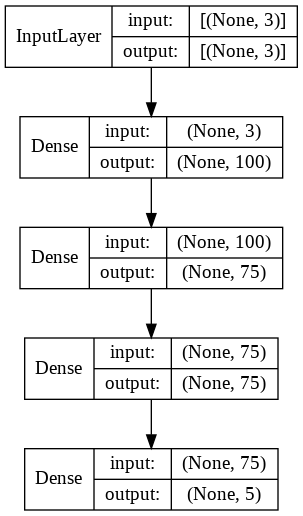

In [44]:
# Saving keras model
model.save("match-predictor.h5")
plot_model(model, to_file="predictor-arch.png",show_layer_names=False, show_shapes=True)

In [45]:
features_train.shape

(80, 3)

In [46]:
from keras.models import load_model

In [47]:
model.save("test.json")

INFO:tensorflow:Assets written to: test.json/assets


In [48]:
x = load_model("test.json")

In [49]:
x.predict(np.array([ [3,0, 1]])) # Match against  Pune and Sunrisers

array([[4.9500802e-01, 4.2129820e-03, 1.2101517e-02, 4.8867330e-01,
        4.2005108e-06]], dtype=float32)

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA()
import matplotlib.pyplot as plt

In [51]:
pca.fit(StandardScaler().fit_transform(features))

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

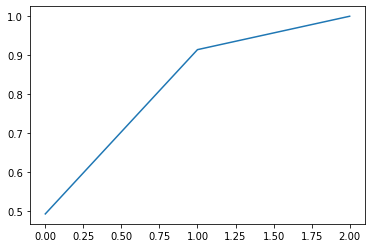

In [52]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))